### Importing the libraries

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


## Part 1 - Read File

In [3]:
# Step 1: Data Collection
# Load the dataset
#uvicData = pd.read_csv('project.csv')
uvicData = pd.read_csv("/content/CaptstoneProjectData_2024.csv")
#uvicData = pd.read_csv('/content/sample_data/emails.csv',error_bad_lines=False)
# dataa='/content/sample_data/emails.csv'
# uvicData=pd.read_csv(dataa,nrows=7085)
uvicData.head()

,Subject,Body,Unnamed: 2,Unnamed: 3
0,®Review your shipment details / Shipment Notif...,Notice: This message was sent from outside the...,NaN,NaN
1,Υоur ассоunt іѕ оn hоld,\r\nVotre réponse a bien été prise en compte.\...,NaN,NaN
2,Completed: Invoice # KZ89TYS2564 from-Bestbuy....,Notice: This message was sent from outside the...,NaN,NaN
3,UVic IMPORTANT NOTICE!,Your UVIC account has been filed under the lis...,NaN,NaN
4,You have (6) Suspended incoming messages,\r\n\r\nMessage generated from uvic.ca source...,NaN,NaN


## Part 2- Data Preprocessing

In [4]:
# Remove unnecessary columns
uvicData_cleaned = uvicData.drop(columns=['Unnamed: 2', 'Unnamed: 3'], errors='ignore')

# Replace empty 'Subject' with space
uvicData_cleaned['Subject'] = uvicData_cleaned['Subject'].fillna(' ')

# Check and remove rows with missing 'Body'
data_cleaned = uvicData_cleaned.dropna(subset=['Body'])

# Normalize text: convert to lowercase, remove special characters, and trim whitespaces
uvicData_cleaned['Subject'] = uvicData_cleaned['Subject'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()
uvicData_cleaned['Body'] = uvicData_cleaned['Body'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()

# Confirm cleaning
uvicData_cleaned.head()



,Subject,Body
0,review your shipment details shipment notific...,notice this message was sent from outside the ...
1,υоur ассоunt іѕ оn hоld,votre réponse a bien été prise en compte\r\nht...
2,completed invoice kz89tys2564 frombestbuycom ...,notice this message was sent from outside the ...
3,uvic important notice,your uvic account has been filed under the lis...
4,you have 6 suspended incoming messages,message generated from uvicca source\r\n\r\n\...


In [18]:
uvicData_cleaned.shape[0] #There is 2576 phishing emails

2576

In [29]:
# Load the normal emails dataset
import csv
normal_emails='/content/emails.csv'
normData=pd.read_csv(normal_emails,nrows=417730)
# normData=pd.read_csv(normal_emails,on_bad_lines='skip',quoting=csv.QUOTE_NONE)
#df = pd.read_csv(file_path, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
normData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417730 entries, 0 to 417729
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     417730 non-null  object
 1   message  417730 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


417730

In [30]:
normData.shape[0]

417730

In [31]:
def parse_email(message):
    lines = message.split('\n')
    subject = next((line.split(": ", 1)[1] for line in lines if line.lower().startswith('subject: ')), "")
    body_start = next(i for i, line in enumerate(lines) if line.strip() == '') + 1
    body = "\n".join(lines[body_start:])
    return subject, body

# Apply the function to the 'message' column
normData[['Subject', 'Body']] = normData['message'].apply(lambda x: pd.Series(parse_email(x)))
normData.head()

,file,message,Subject,Body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Re: Hello,Let's shoot for Tuesday at 11:45.


In [32]:
normData['Subject'] = normData['Subject'].fillna(' ')
normData = normData.dropna(subset=['Body'])
normData = normData.drop(columns=['file', 'message'], errors='ignore')
# Normalize text: convert to lowercase, remove special characters, and trim whitespaces
normData['Subject'] = normData['Subject'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()
normData['Body'] = normData['Body'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()

# Showing the updated DataFrame with subject and body columns
normData.head()

,Subject,Body
0,,here is our forecast
1,re,traveling to have a business meeting takes the...
2,re test,test successful way to go
3,,randy\n\n can you send me a schedule of the sa...
4,re hello,lets shoot for tuesday at 1145


In [33]:
uvicData_cleaned['label'] = 1 # Phishing emails
normData['label'] = 0 # Normal Enails

masterData = pd.concat([uvicData_cleaned, normData], ignore_index=True)
masterData.head()

,Subject,Body,label
0,review your shipment details shipment notific...,notice this message was sent from outside the ...,1
1,υоur ассоunt іѕ оn hоld,votre réponse a bien été prise en compte\r\nht...,1
2,completed invoice kz89tys2564 frombestbuycom ...,notice this message was sent from outside the ...,1
3,uvic important notice,your uvic account has been filed under the lis...,1
4,you have 6 suspended incoming messages,message generated from uvicca source\r\n\r\n\...,1


In [34]:
masterData.shape[0]

420306

In [35]:
# Split the data into features (X) and target (y)
X = masterData.drop('label', axis=1)
y = masterData['label']
masterData.dtypes
# # Split the data into features (X) and target (y)
# X = uvicData_cleaned.drop('label', axis=1)
# y = uvicData_cleaned['label']
# uvicData_cleaned.dtypes



Subject    object
Body       object
label       int64
dtype: object

### Convert Data (Strings) to Numbers

In [36]:
#We need to convert strings into float for processing

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_attributes= ["Subject","Body"]
one_hot=OneHotEncoder()
transformer = ColumnTransformer([("one_hot",one_hot,categorical_attributes,)],remainder="passthrough")
transformedX=transformer.fit_transform(X)
transformedX

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# themodel = RandomForestClassifier()
# themodel.fit(X_train, y_train)

<420306x327500 sparse matrix of type '<class 'numpy.float64'>'
	with 840612 stored elements in Compressed Sparse Row format>

In [ ]:
#An alternative using get_dummies
#pd.DataFrame(transformedX)
dummy = pd.get_dummies(masterData[["Subject","Body"]])
dummy


Train and Test

In [37]:
np.random.seed(42)



# # Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(transformedX, y, test_size=0.1)
themodel = RandomForestClassifier(n_estimators=3)
themodel.fit(X_train, y_train)

#
# themodel = RandomForestClassifier()
# param_dist = {'n_estimators': randint(50,500),
#               'max_depth': randint(1,20)}
# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(themodel,
#                                  param_distributions = param_dist,
#                                  n_iter=5,
#                                  cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)



RandomForestClassifier(n_estimators=3)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

NameError: name 'rand_search' is not defined

In [38]:
themodel.score(X_test,y_test)

0.9946943922343032

In [39]:
y_pred = themodel.predict(X_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9946943922343032


In [41]:
# Export the first three decision trees from the forest
encoder = OneHotEncoder()
X_train.todense()
X_train_encoded = encoder.fit_transform(X_train)
feature_names = encoder.get_feature_names_out()
for i in range(3):
    tree = themodel.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [16]:
y_pred
# # Generate predictions with the best model
# y_pred = best_rf.predict(X_test)

# # Create the confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# ConfusionMatrixDisplay(confusion_matrix=cm).plot();

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
y_pred = themodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9946943922343032
Precision: 1.0
Recall: 0.1647940074906367


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     41764
           1       1.00      0.16      0.28       267

    accuracy                           0.99     42031
   macro avg       1.00      0.58      0.64     42031
weighted avg       0.99      0.99      0.99     42031

Accuracy: 0.9946943922343032
Confusion Matrix:
[[41764     0]
 [  223    44]]


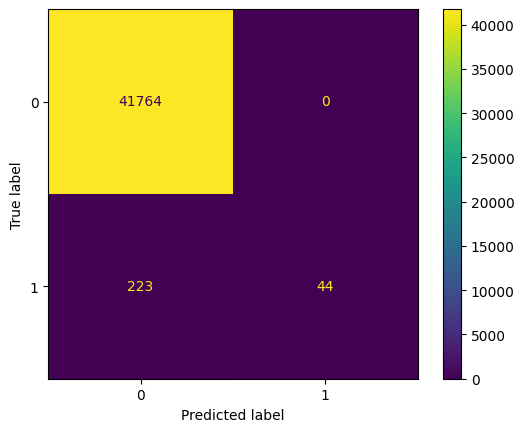

In [43]:

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
